In [ ]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 14.39 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Updating files: 100% (182401/182401), done.


Downloading...
From: https://drive.google.com/uc?id=1-Tb-7Lx4MgV0RsDtI-rYK3Nk2aa1wTrV
To: /content/a.h5
100% 96.6M/96.6M [00:00<00:00, 197MB/s]


Downloading...
From: https://drive.google.com/uc?id=16njZhZg9Qv3pbK6feQtWuII9D8kW0yxB
To: /content/b.h5
100% 19.6M/19.6M [00:00<00:00, 155MB/s]


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
class Dataset:

    def __init__(self, dataset_path: str):
        self.PARENT = dataset_path
        self.class_distribution = dict()

    def __compute_class_distributions(self):
        for dirname in os.listdir(self.PARENT):
            self.class_distribution[dirname] = len(os.listdir(os.path.join(self.PARENT, dirname)))

    def class_distributions(self):
        self.__compute_class_distributions()

        plt.figure(figsize=(10,10))
        plt.bar(self.class_distribution.keys(),
                self.class_distribution.values(),
                color=["crimson","red","orange","yellow"])
        plt.xticks(rotation=90)
        plt.title("Class Distribution of PlantVillage dataset")
        plt.xlabel("Class Label")
        plt.ylabel("Frequency of class")
        plt.show()

    def show_class_samples(self):
        rows = 6
        columns = 3
        c = 0
        fig, axs = plt.subplots(rows, columns, figsize=(32,32))
        for dirname in os.listdir(self.PARENT):
            img_path = r.choice(os.listdir(os.path.join(self.PARENT, dirname)))
            image = mpimg.imread(os.path.join(self.PARENT, dirname, img_path))
            axs[c//columns, c%columns].imshow(image)
            axs[c//columns, c%columns].set_title(dirname)
            c += 1
            if c//columns==rows-1:
              break;
        fig.suptitle("Image Samples of Plant Village dataset")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()


In [ ]:
pv = Dataset("/content/PlantVillage-Dataset/raw/color")

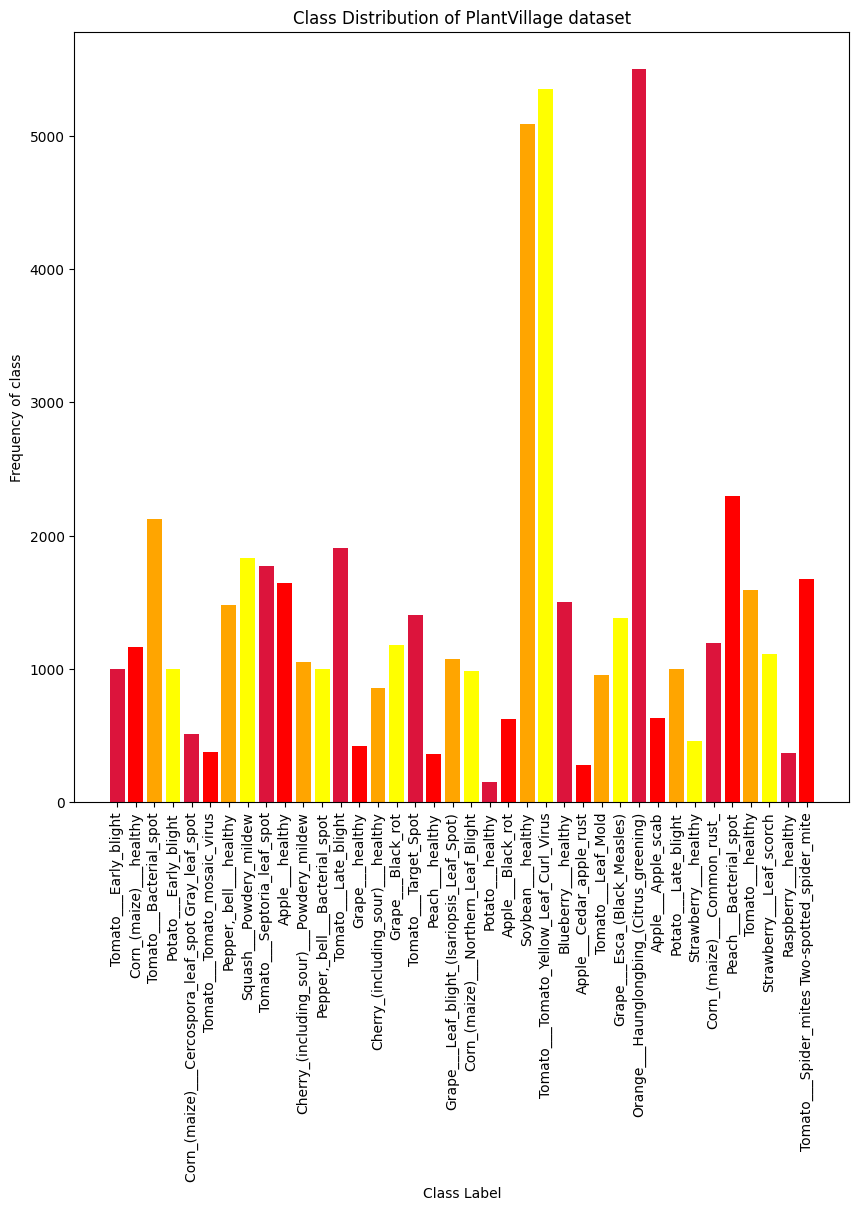

In [ ]:
pv.class_distributions()

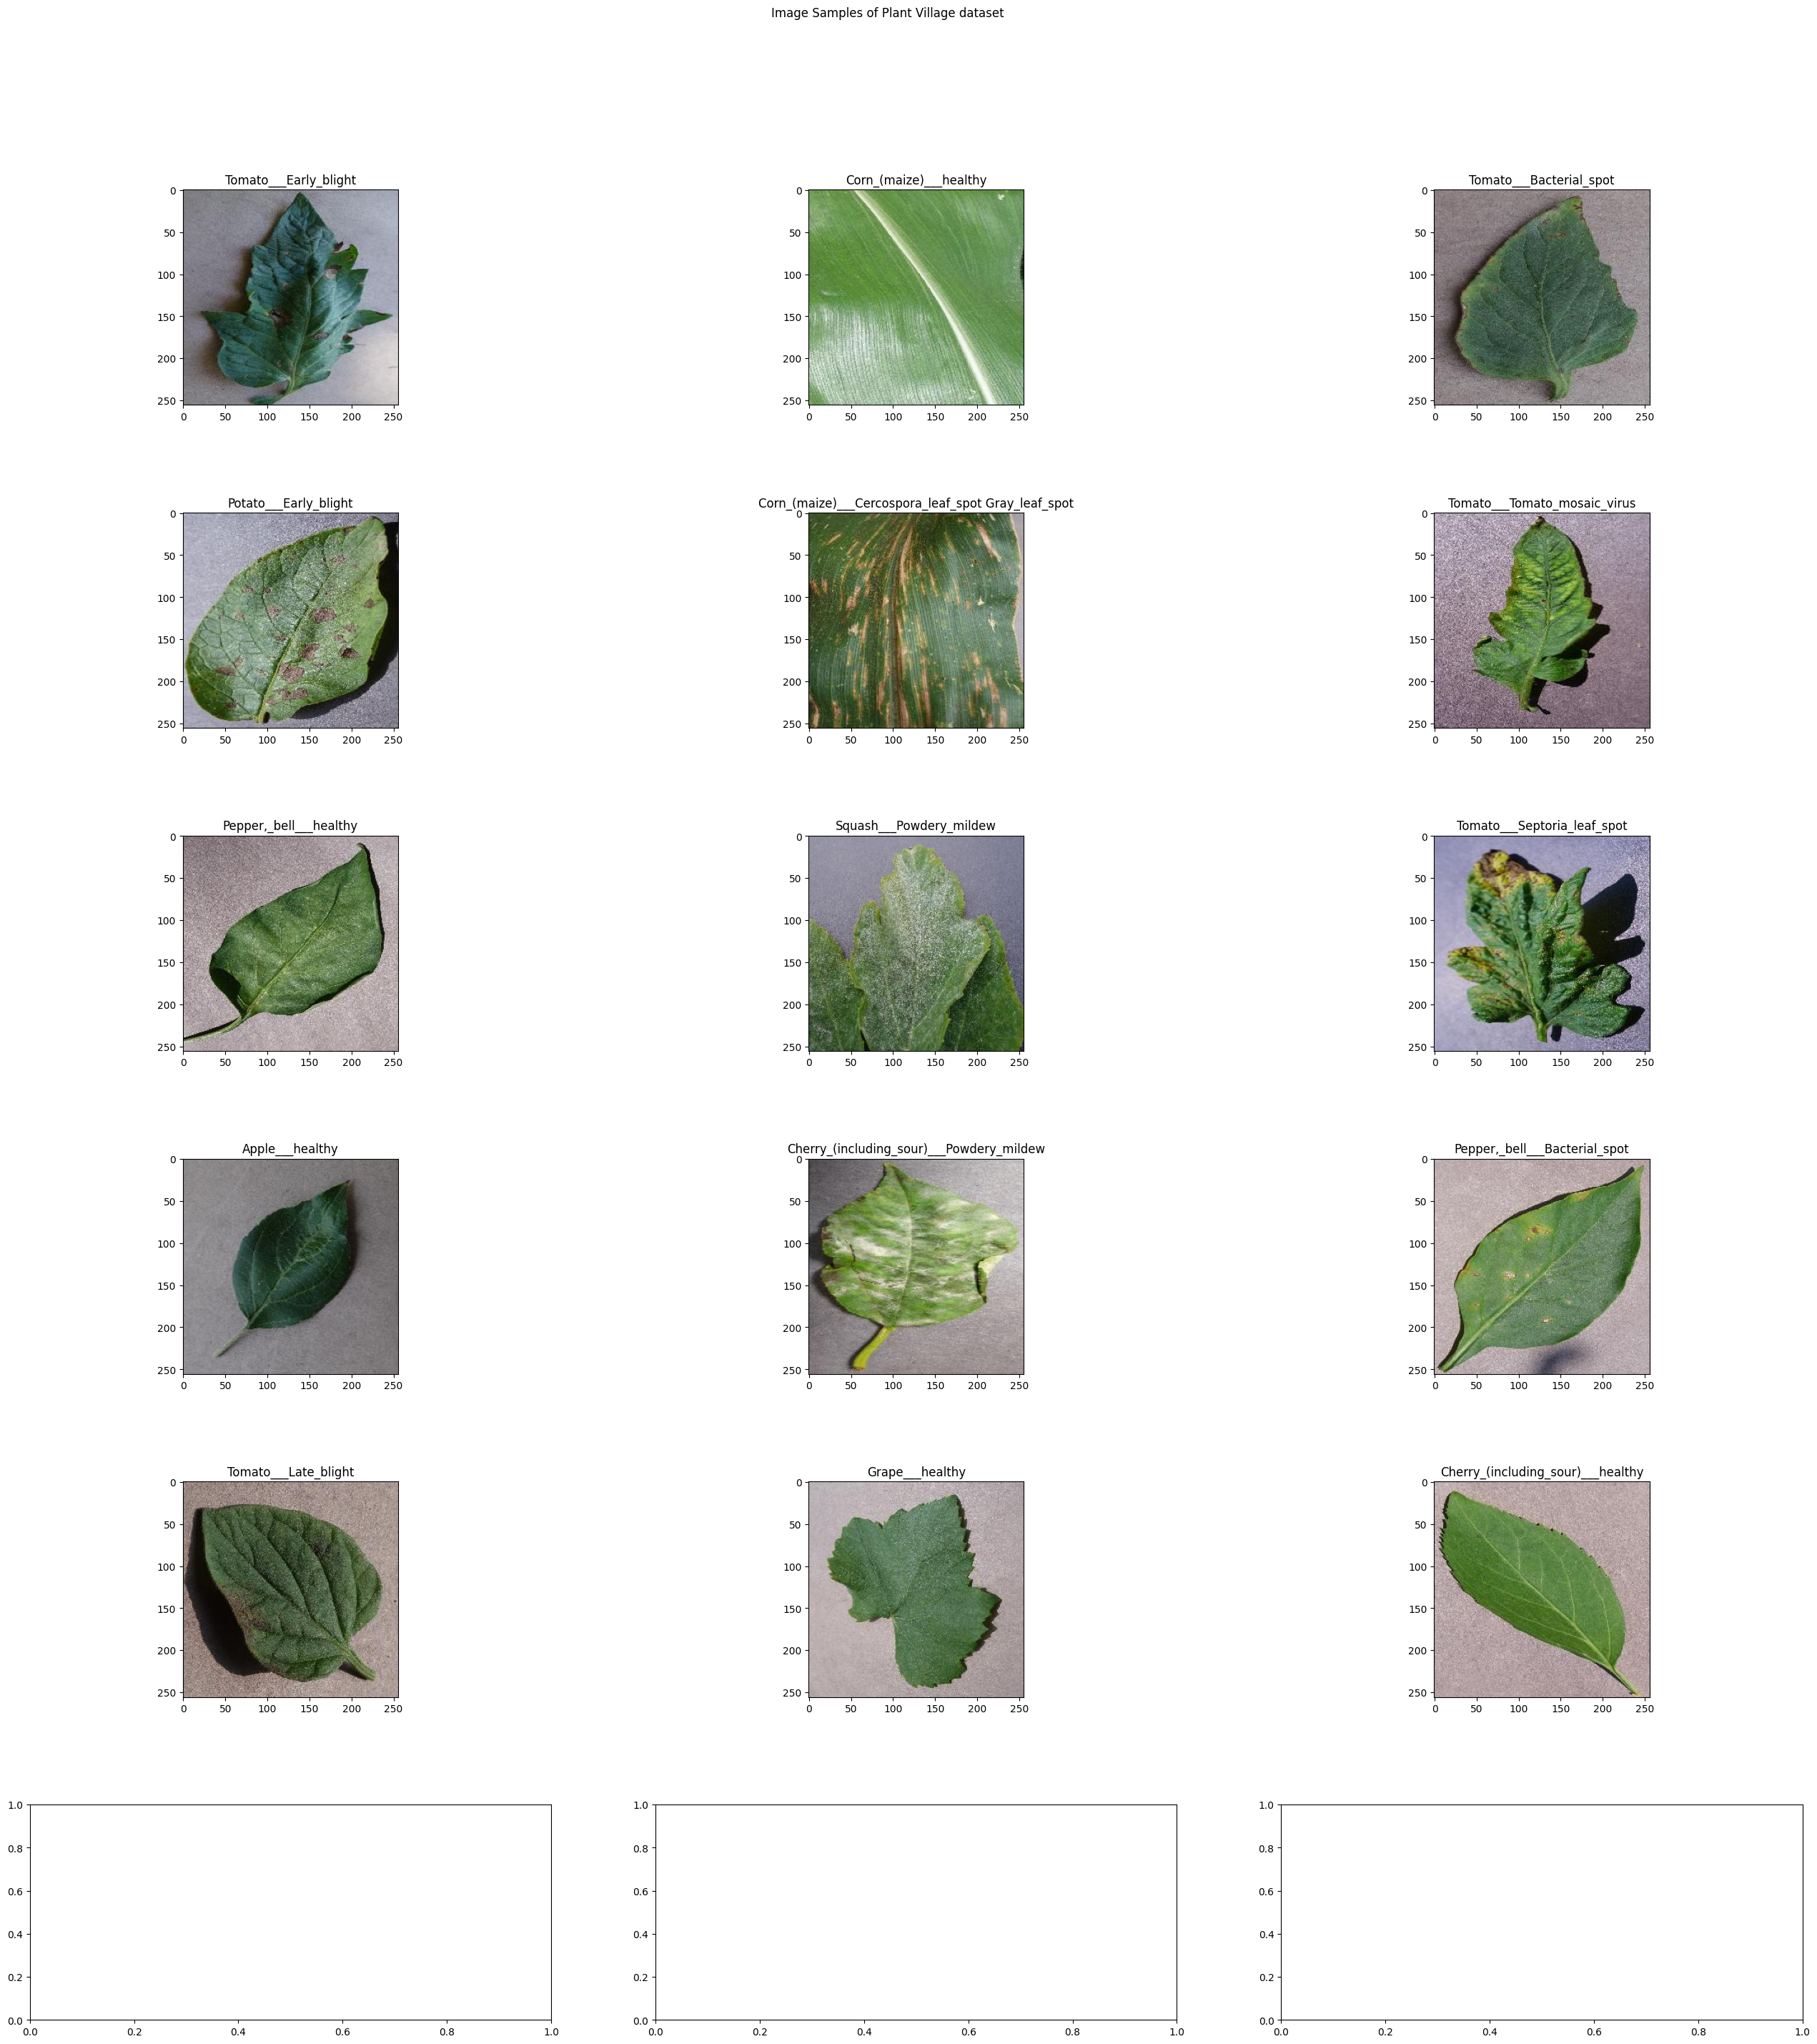

In [ ]:
import random as r
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
pv.show_class_samples()

43/43 [==============================] - 61s 1s/step - loss: 0.2805 - accuracy: 0.9193
Validation Accuracy: 91.93%


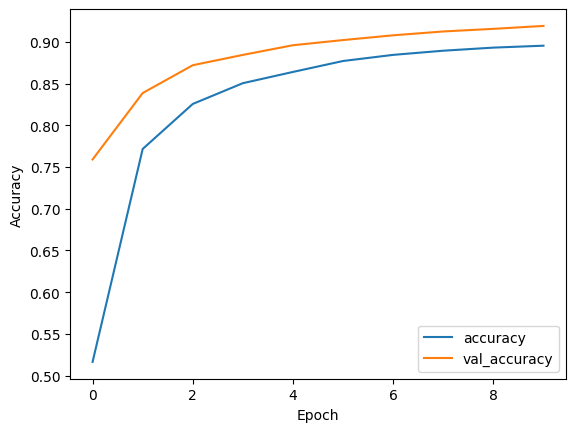

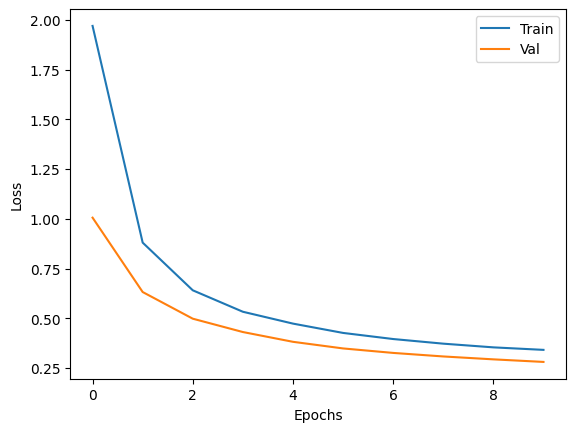

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import Xception,MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

num_classes=38

# Load the PlantVillage dataset and count the number of samples in each class
dataset_path = '/content/PlantVillage-Dataset/raw/color'
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort the classes by their sample counts and take the top num_classes classes
top_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:num_classes]

# Load Xception model pre-trained on ImageNet
base_model = Xception(weights='imagenet', include_top=False,input_shape=(256, 256, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of Xception
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Load dataset using ImageDataGenerator with subset argument
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
   target_size=(256, 256),
    batch_size=256,
    class_mode='categorical',
    subset='training',
    #classes=top_classes
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=256,
    class_mode='categorical',
    subset='validation',
   #classes=top_classes
)
from keras.callbacks import ModelCheckpoint

# Define the directory to save checkpoints
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define the filepath for the checkpoint
checkpoint_filepath = os.path.join(checkpoint_dir, 'weights-{epoch:02d}-{val_accuracy:.2f}.h5')

# Create ModelCheckpoint callback to save weights
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # Monitoring validation accuracy
    save_weights_only=True,  # Save only the weights
    save_best_only=False,  # Save weights at every checkpoint
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    #steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
   # validation_steps=validation_generator.samples // validation_generator.batch_size
    callbacks=[checkpoint_callback]
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.show()


In [ ]:
model.save("a.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import Xception,MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

num_classes=38

# Load the PlantVillage dataset and count the number of samples in each class
dataset_path = '/content/PlantVillage-Dataset/raw/color'
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort the classes by their sample counts and take the top num_classes classes
top_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:num_classes]

# Load Xception model pre-trained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False,input_shape=(256, 256, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of Xception
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Load dataset using ImageDataGenerator with subset argument
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
   target_size=(256, 256),
    batch_size=256,
    class_mode='categorical',
    subset='training',
    #classes=top_classes
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=256,
    class_mode='categorical',
    subset='validation',
   #classes=top_classes
)

17225924/17225924 [==============================] - 0s 0us/step
Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    #steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
   # validation_steps=validation_generator.samples // validation_generator.batch_size

)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

Epoch 1/10
170/170 [==============================] - 183s 1s/step - loss: 1.9440 - accuracy: 0.5080 - val_loss: 0.6663 - val_accuracy: 0.8428
Epoch 2/10
170/170 [==============================] - 160s 942ms/step - loss: 0.7115 - accuracy: 0.8024 - val_loss: 0.3267 - val_accuracy: 0.9124
Epoch 3/10
170/170 [==============================] - 149s 878ms/step - loss: 0.4573 - accuracy: 0.8659 - val_loss: 0.2353 - val_accuracy: 0.9346
Epoch 4/10
170/170 [==============================] - 151s 885ms/step - loss: 0.3570 - accuracy: 0.8934 - val_loss: 0.1952 - val_accuracy: 0.9436
Epoch 5/10
170/170 [==============================] - 150s 883ms/step - loss: 0.3041 - accuracy: 0.9066 - val_loss: 0.1746 - val_accuracy: 0.9478
Epoch 6/10
170/170 [==============================] - 151s 887ms/step - loss: 0.2736 - accuracy: 0.9149 - val_loss: 0.1556 - val_accuracy: 0.9553
Epoch 7/10
170/170 [==============================] - 149s 878ms/step - loss: 0.2451 - accuracy: 0.9225 - val_loss: 0.1464 - va

In [ ]:
model.save("b.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


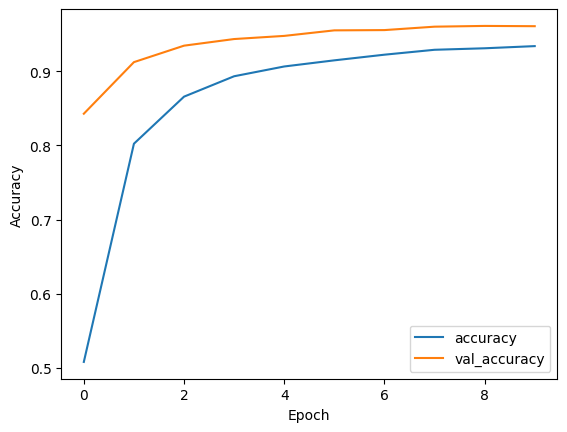

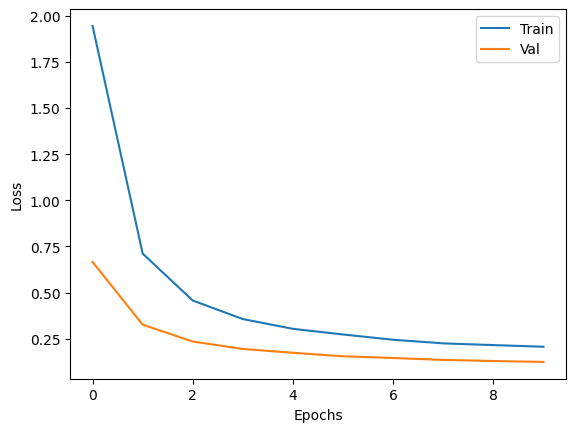

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

# Assuming you have loaded your model and validation data
model = load_model('b.h5')
dataset_path = '/content/PlantVillage-Dataset/raw/color'


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=256,
    class_mode='categorical',
    subset='validation',
    shuffle = False,
   #classes=top_classes
)
# Make predictions on validation data
y_true = validation_generator.classes  # True labels
y_pred_prob = model.predict(validation_generator)  # Predicted probabilities for each class
y_pred = y_pred_prob.argmax(axis=1)  # Predicted labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate classification report
cls_report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys())

# Print the performance metrics
print("\n")
print("Accuracy:", accuracy)
print("\n")
print("Precision:", precision)
print("\n")
print("Recall:", recall)
print("\n")
print("F1-score:", f1)
print("\n")
print("\nClassification Report:")
print(cls_report)


Found 10849 images belonging to 38 classes.
43/43 [==============================] - 33s 752ms/step


Accuracy: 0.9609180569637754


Precision: 0.9614045065609084


Recall: 0.9609180569637754


F1-score: 0.9608622096385945



Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.92      0.95      0.94       126
                                 Apple___Black_rot       1.00      0.97      0.98       124
                          Apple___Cedar_apple_rust       0.98      0.98      0.98        55
                                   Apple___healthy       0.98      0.97      0.98       329
                               Blueberry___healthy       0.99      0.99      0.99       300
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       210
                 Cherry_(including_sour)___healthy       0.99      0.98      0.98       170
Corn_(maize)__

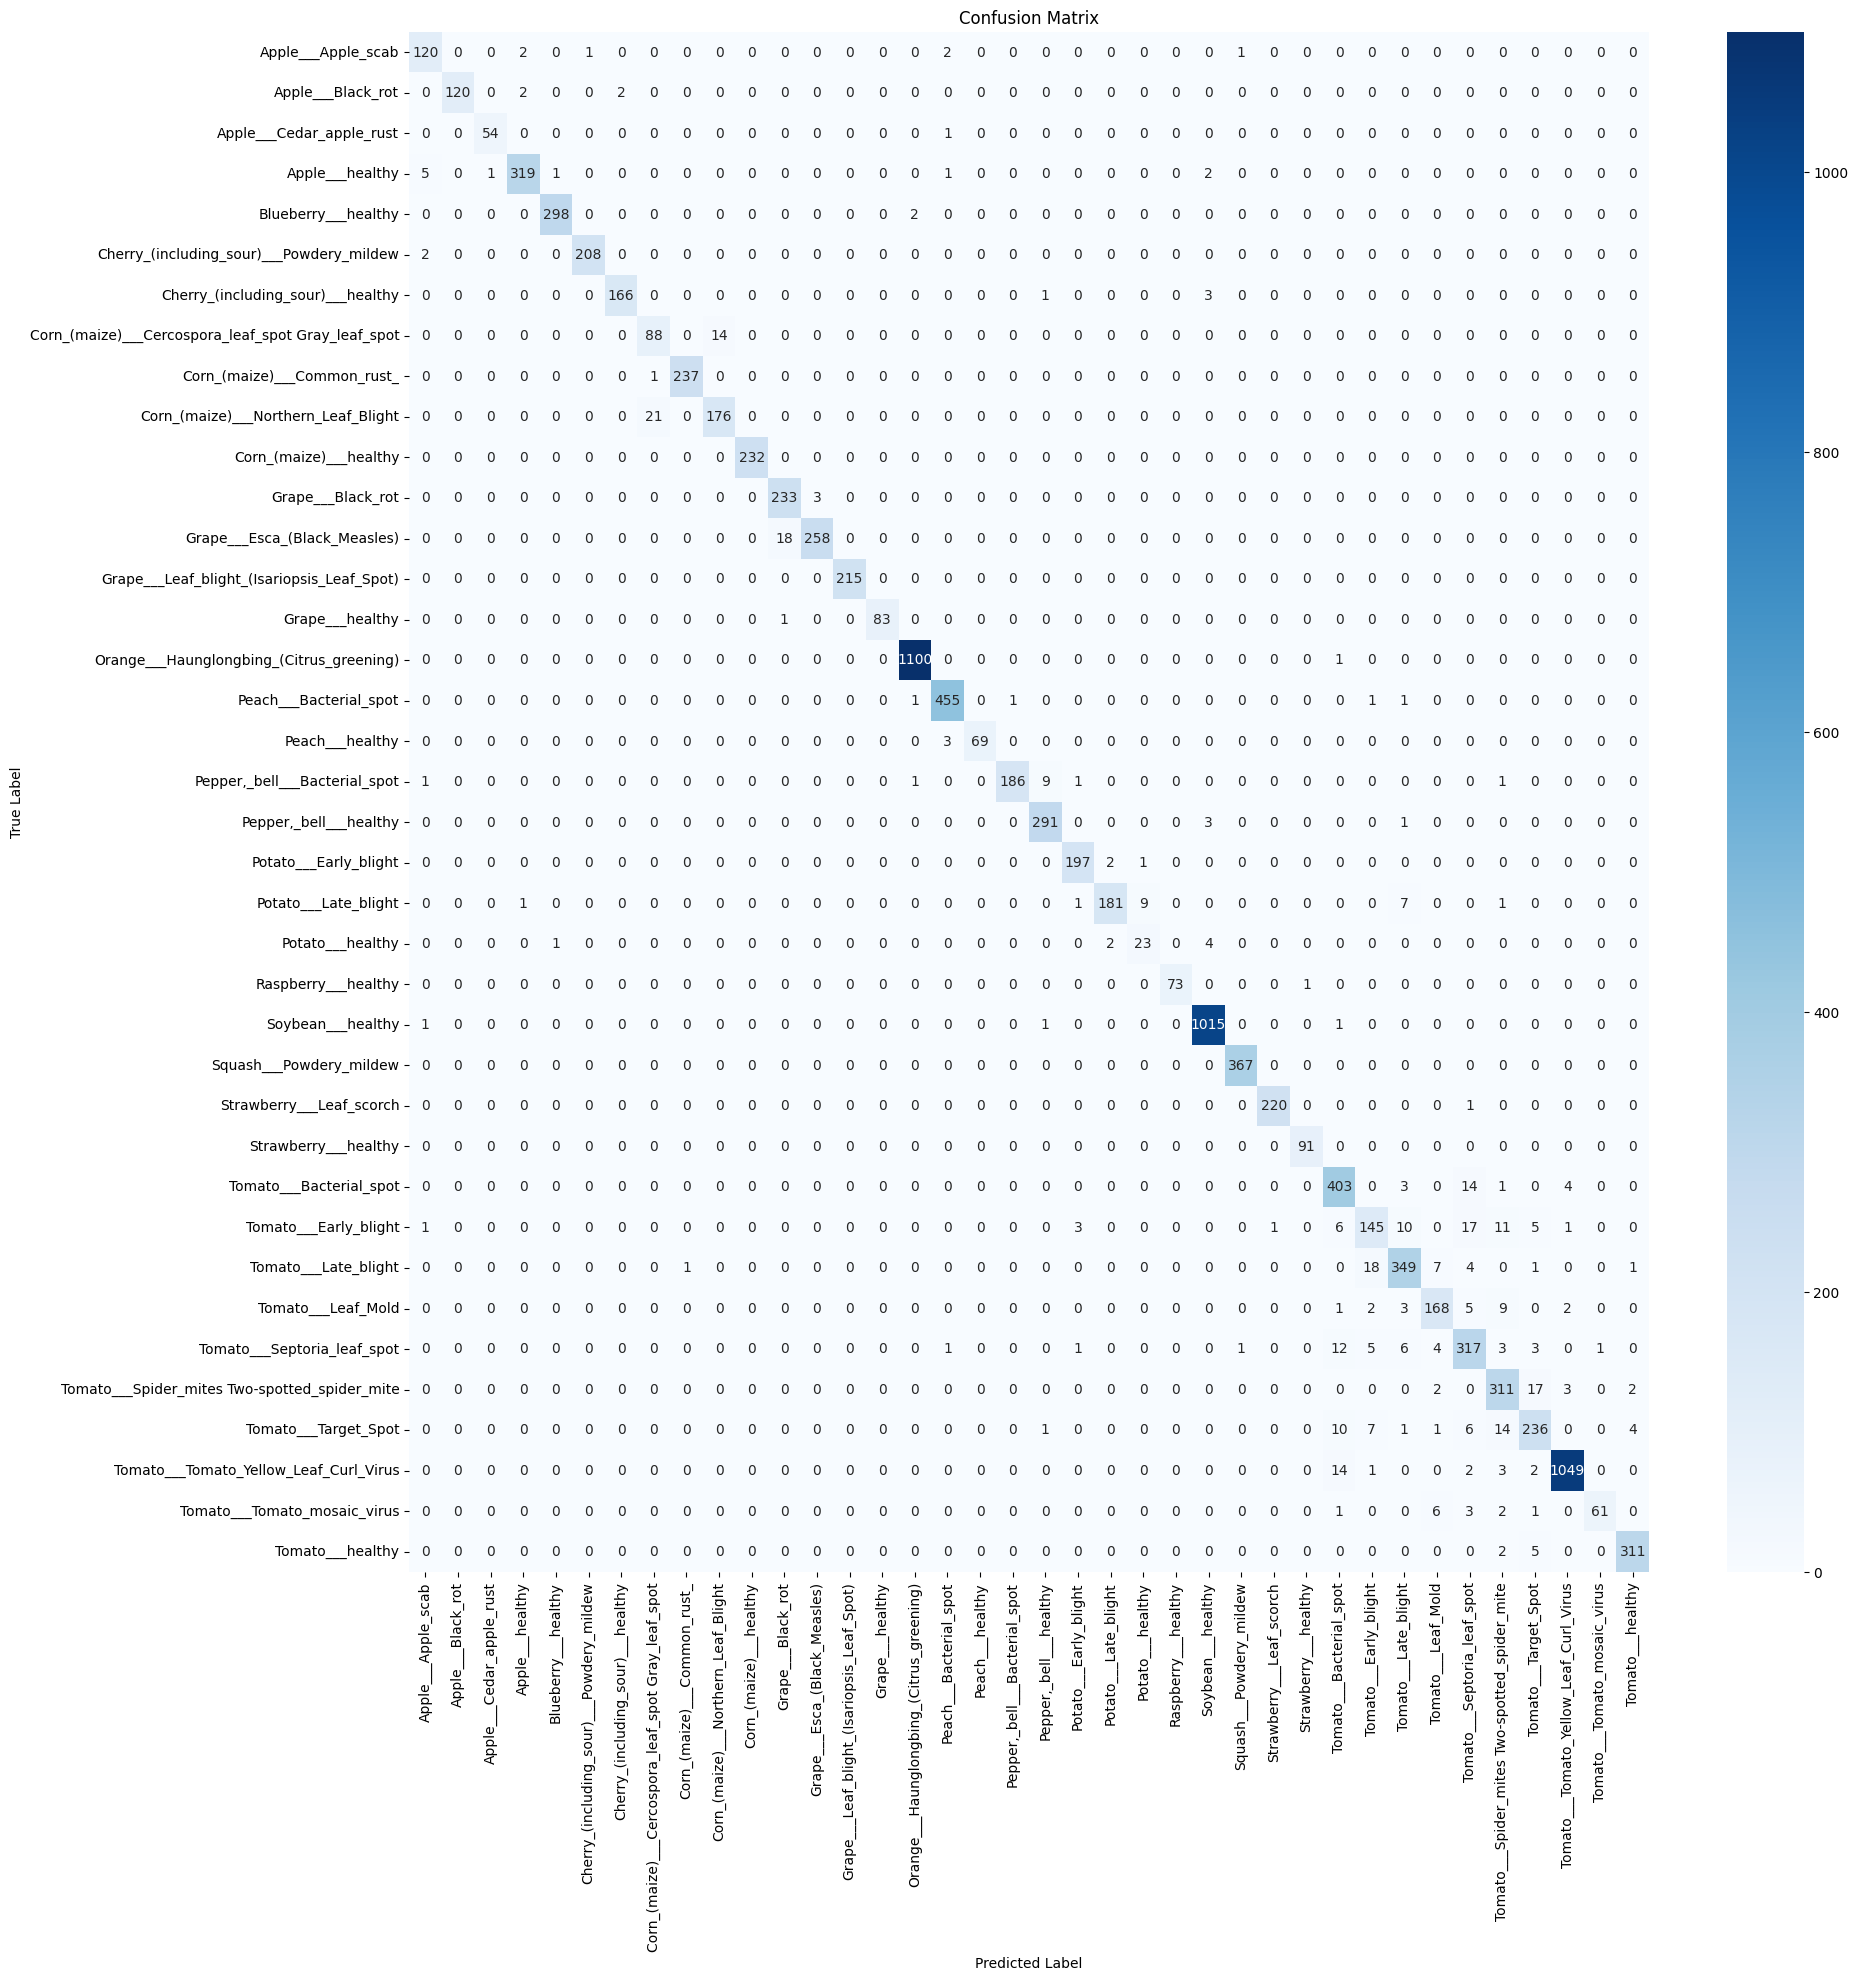

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

# Assuming you have loaded your model and validation data
model = load_model('a.h5')
dataset_path = '/content/PlantVillage-Dataset/raw/color'


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=256,
    class_mode='categorical',
    subset='validation',
    shuffle = False,
   #classes=top_classes
)
# Make predictions on validation data
y_true = validation_generator.classes  # True labels
y_pred_prob = model.predict(validation_generator)  # Predicted probabilities for each class
y_pred = y_pred_prob.argmax(axis=1)  # Predicted labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate classification report
cls_report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys())

# Print the performance metrics
print("\n")
print("Accuracy:", accuracy)
print("\n")
print("Precision:", precision)
print("\n")
print("Recall:", recall)
print("\n")
print("F1-score:", f1)
print("\n")
print("\nClassification Report:")
print(cls_report)


Found 10849 images belonging to 38 classes.
43/43 [==============================] - 99s 2s/step
Accuracy: 0.9192552308968569


Precision: 0.9192357047542751


Recall: 0.9192552308968569


F1-score: 0.9184580472719245



Confusion Matrix:

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.93      0.82      0.87       126
                                 Apple___Black_rot       0.92      0.89      0.91       124
                          Apple___Cedar_apple_rust       0.96      0.84      0.89        55
                                   Apple___healthy       0.91      0.92      0.92       329
                               Blueberry___healthy       0.97      0.95      0.96       300
          Cherry_(including_sour)___Powdery_mildew       0.98      0.97      0.97       210
                 Cherry_(including_sour)___healthy       0.94      0.95      0.94       170


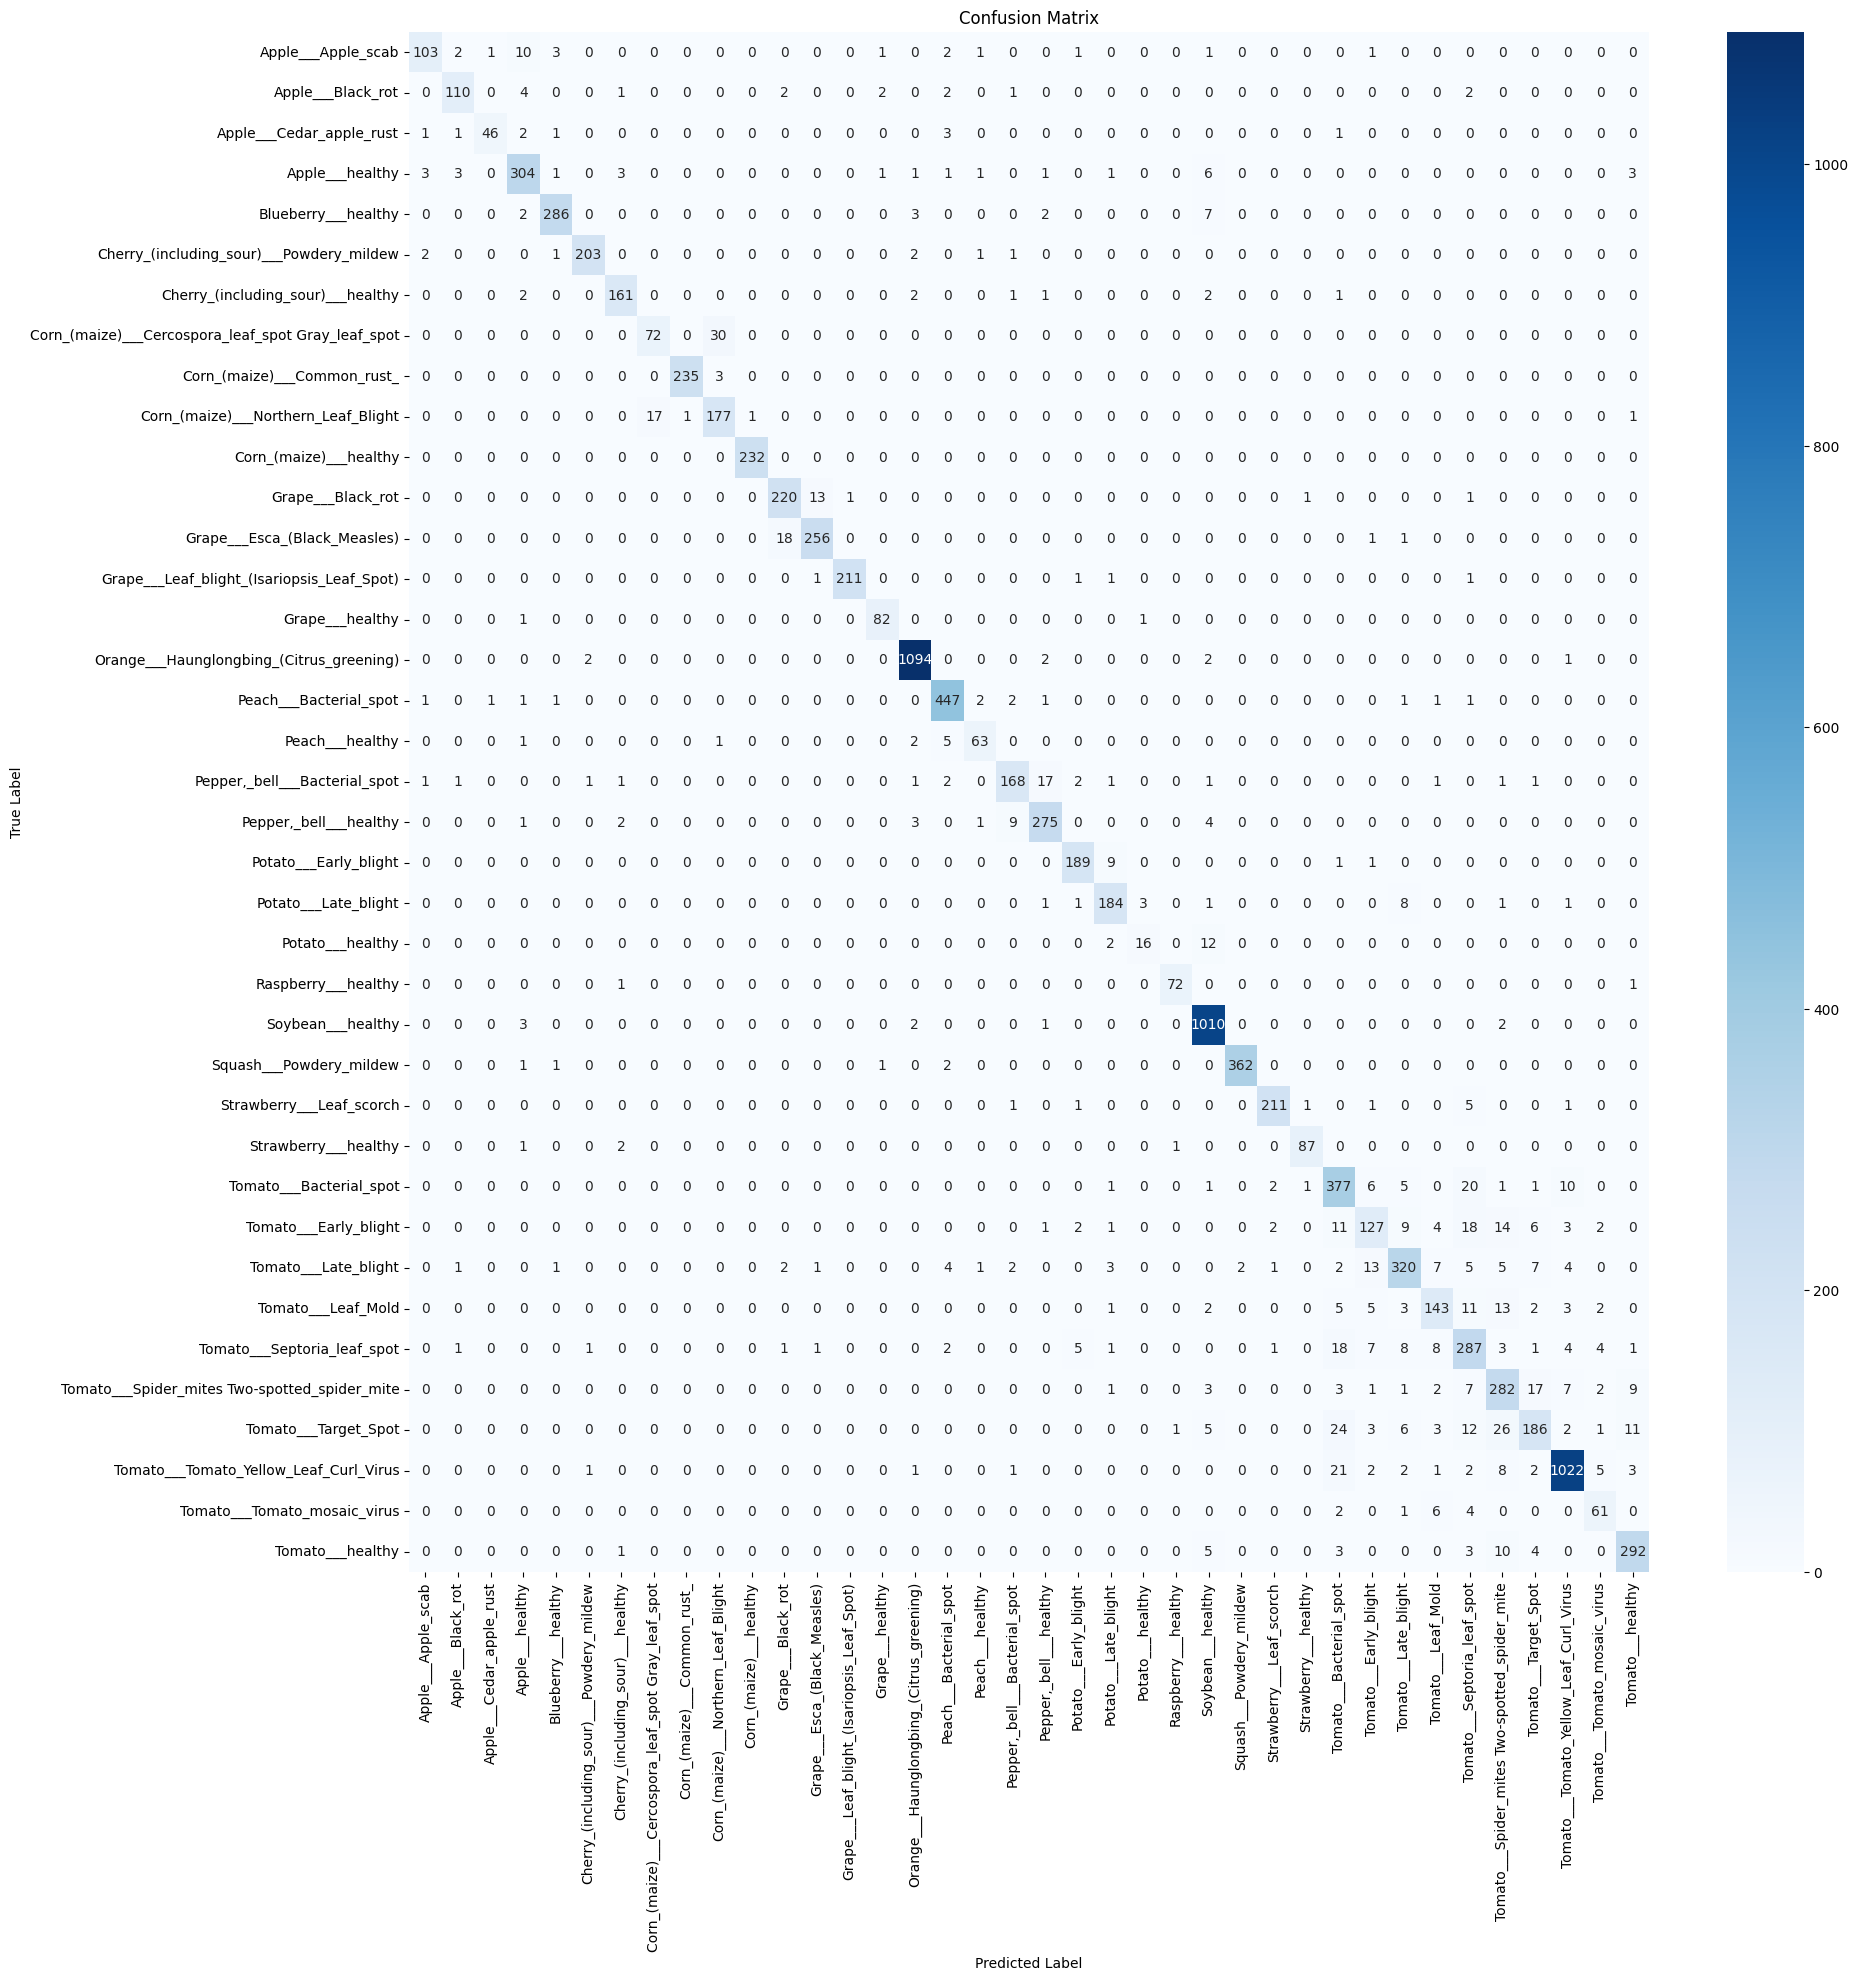

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from keras.preprocessing import image
import numpy as np
import os

test_image_path = '/content/Northern-Corn-Leaf-Blight-1-e1687461214618.png'
img = image.load_img(test_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = img_array / 255.0

from keras.models import load_model
model = load_model('/content/b.h5')

# Get class labels from directory structure
class_labels = sorted(os.listdir('/content/PlantVillage-Dataset/raw/color'))  # Replace with the path to your training data directory

# Make predictions
predictions = model.predict(img_array)
predicted_class_idx = np.argmax(predictions)
predicted_label = class_labels[predicted_class_idx]

# Print the predicted class label
print("Predicted class:", predicted_label)


1/1 [==============================] - 0s 407ms/step
Predicted class: Corn_(maize)___Northern_Leaf_Blight
